# Project 5 – Ensemble Models for Wine Quality

- **Author:** Deb St. Cyr 
- **Date:** November 2025 

In this project, I use ensemble machine learning models to predict red wine quality based on physicochemical properties. I focus on:

- Preparing and encoding the wine quality dataset.
- Training and evaluating several ensemble models.
- Comparing their performance using accuracy and F1 score.
- Looking at train–test “gaps” to understand overfitting and generalization.

The main target is red wine quality, grouped into three categories (low, medium, high). This project focuses entirely on the red wine quality dataset.


## Executive Summary

This project evaluates a variety of ensemble machine learning models to predict red wine quality using eleven physicochemical features. After training and analyzing nine different ensemble configurations, two models stood out as strong performers:

- **Random Forest (100 estimators)** – highest overall test accuracy (0.8875) and strong F1 score (0.8661), with clear interpretability through feature importances.
- **Gradient Boosting (100 estimators)** – competitive accuracy (0.8562) with less overfitting and more stable generalization.

Random Forest provided the best raw performance, while Gradient Boosting offered better regularization and robustness. Both models were selected for deeper analysis, including confusion matrix visualization and feature importance evaluation.

Key findings include:
- Medium-quality wines dominate the dataset and are predicted most accurately across all models.
- High-quality wines are often misclassified as medium due to class imbalance and overlapping chemical profiles.
- Alcohol, sulphates, volatile acidity, and density emerged as highly influential predictors across ensemble models.

This project demonstrates the strength of ensemble techniques on tabular chemical datasets and highlights trade-offs between bagging-based and boosting-based approaches.


In [16]:
# ------------------------------------------------
# Imports once at the top, organized
# ------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Section 1. Load and Inspect the Data

In this section, I load the red wine quality dataset from the UCI Machine Learning Repository and take a first look at its structure.

The dataset contains 11 physicochemical features (acidity, sugar, alcohol, etc.) and one target column (`quality`, an integer rating from 0–10).  

I also load the `spiral.csv` dataset that was used in the Lab 5 example to visualize a more complex classification problem.


In [28]:
# Load the dataset (download from UCI and save in the same folder)
df = pd.read_csv("data/winequality-red.csv", sep=";")

# Display structure and first few rows
df.info()
df.head()

# The dataset includes 11 physicochemical input variables (features):
# ---------------------------------------------------------------
# - fixed acidity          mostly tartaric acid
# - volatile acidity       mostly acetic acid (vinegar)
# - citric acid            can add freshness and flavor
# - residual sugar         remaining sugar after fermentation
# - chlorides              salt content
# - free sulfur dioxide    protects wine from microbes
# - total sulfur dioxide   sum of free and bound forms
# - density                related to sugar content
# - pH                     acidity level (lower = more acidic)
# - sulphates              antioxidant and microbial stabilizer
# - alcohol                % alcohol by volume

# The target variable is:
# - quality (integer score from 0 to 10, rated by wine tasters)

# We will simplify this target into three categories:
#   - low (3–4), medium (5–6), high (7–8) to make classification feasible.
#   - we will also make this numeric (we want both for clarity)
# The dataset contains 1599 samples and 12 columns (11 features + target).


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Section 2. Prepare the Data

The original `quality` column is an integer score (0–10). To make the classification problem more tractable and align with the instructions, I:

- Map `quality` into three label categories:
  - **low**: scores 3–4
  - **medium**: scores 5–6
  - **high**: scores 7–8
- Create:
  - `quality_label` – a human-readable string label (`low`, `medium`, `high`)
  - `quality_numeric` – a numeric label (0, 1, 2) for modeling


In [29]:
# Map numeric quality to string label
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_label"] = df["quality"].apply(quality_to_label)

# Map numeric quality to a numeric class (0, 1, 2)
def quality_to_number(q):
    if q <= 4:
        return 0  # low
    elif q <= 6:
        return 1  # medium
    else:
        return 2  # high

df["quality_numeric"] = df["quality"].apply(quality_to_number)

df[["quality", "quality_label", "quality_numeric"]].head()


,quality,quality_label,quality_numeric
0,5,medium,1
1,5,medium,1
2,5,medium,1
3,6,medium,1
4,5,medium,1


### Medium dominates the class balance

In [30]:
df["quality_label"].value_counts()


quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64

# Section 3. Feature Selection and Justification

The dataset has 11 numeric physicochemical features and 1 target (`quality`).  
For modeling, I use:

- **Features (X):** all original numeric physicochemical variables  
  – I drop `quality`, `quality_label`, and `quality_numeric` so they are not used as inputs.

- **Target (y):** `quality_numeric` (0 = low, 1 = medium, 2 = high)

All the physicochemical features are potentially meaningful for predicting wine quality (e.g., acidity, alcohol, sulphates), so I keep the full set rather than manually removing any at this stage.


In [38]:
# Define input features (X) and target (y)
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])
y = df["quality_numeric"]

X.shape, y.shape


((1599, 11), (1599,))

# Section 4. Split the Data into Train and Test Sets

I use an 80/20 train–test split:

- **Training set:** used to fit the models.
- **Test set:** held out to evaluate generalization.

I also use `stratify=y` so that the class proportions (low/medium/high) are similar in both train and test sets.


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((1279, 11), (320, 11))

# Section 5. Train and Evaluate Ensemble Models

In this section, I train several ensemble models and compute:

- Train and test accuracy
- Train and test weighted F1 score
- Confusion matrix on the test set

I then store all results in a list so I can convert them to a DataFrame for comparison.


In [40]:
# Helper function to train and evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )


In [42]:
results = []

# 1. Random Forest (100)
evaluate_model(
    "Random Forest (100)",
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 2. Random Forest (200, max_depth=10)
evaluate_model(
    "Random Forest (200, max_depth=10)",
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 3. AdaBoost (100)
evaluate_model(
    "AdaBoost (100)",
    AdaBoostClassifier(n_estimators=100, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 4. AdaBoost (200, lr=0.5)
evaluate_model(
    "AdaBoost (200, lr=0.5)",
    AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 5. Gradient Boosting (100)
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 6. Voting Classifier (DT, SVM, NN)
voting1 = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier()),
        ("SVM", SVC(probability=True)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ],
    voting="soft",
)
evaluate_model(
    "Voting (DT + SVM + NN)", voting1, X_train, y_train, X_test, y_test, results
)

# 7. Voting Classifier (RF, LR, KNN)
voting2 = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=100)),
        ("LR", LogisticRegression(max_iter=1000)),
        ("KNN", KNeighborsClassifier()),
    ],
    voting="soft",
)
evaluate_model(
    "Voting (RF + LR + KNN)", voting2, X_train, y_train, X_test, y_test, results
)

# 8. Bagging (DT, 100)
evaluate_model(
    "Bagging (DT, 100)",
    BaggingClassifier(
        estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 9. MLP Classifier
evaluate_model(
    "MLP Classifier",
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)



Random Forest (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 256   8]
 [  0  15  28]]
Train Accuracy: 1.0000, Test Accuracy: 0.8875
Train F1 Score: 1.0000, Test F1 Score: 0.8661

Random Forest (200, max_depth=10) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 255   9]
 [  0  16  27]]
Train Accuracy: 0.9758, Test Accuracy: 0.8812
Train F1 Score: 0.9745, Test F1 Score: 0.8596

AdaBoost (100) Results
Confusion Matrix (Test):
[[  1  12   0]
 [  5 240  19]
 [  0  20  23]]
Train Accuracy: 0.8342, Test Accuracy: 0.8250
Train F1 Score: 0.8209, Test F1 Score: 0.8158

AdaBoost (200, lr=0.5) Results
Confusion Matrix (Test):
[[  1  12   0]
 [  2 255   7]
 [  0  25  18]]
Train Accuracy: 0.8397, Test Accuracy: 0.8562
Train F1 Score: 0.8160, Test F1 Score: 0.8330

Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  3 247  14]
 [  0  16  27]]
Train Accuracy: 0.9601, Test Accuracy: 0.8562
Train F1 Score: 0.9584, Test F1 Score: 0.8411

Voting (DT + SVM + NN) 

c:\Projects\GitHub_Repos\applied-ml-dstcyr\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Voting (RF + LR + KNN) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 259   5]
 [  0  27  16]]
Train Accuracy: 0.9171, Test Accuracy: 0.8594
Train F1 Score: 0.8992, Test F1 Score: 0.8262

Bagging (DT, 100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 252  12]
 [  0  12  31]]
Train Accuracy: 1.0000, Test Accuracy: 0.8844
Train F1 Score: 1.0000, Test F1 Score: 0.8655

MLP Classifier Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 257   7]
 [  0  30  13]]
Train Accuracy: 0.8514, Test Accuracy: 0.8438
Train F1 Score: 0.8141, Test F1 Score: 0.8073


### Confusion Matrix Heatmaps for Random Forest and Gradient Boosting Models

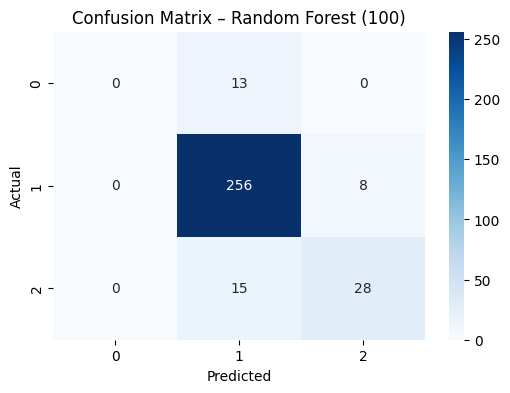

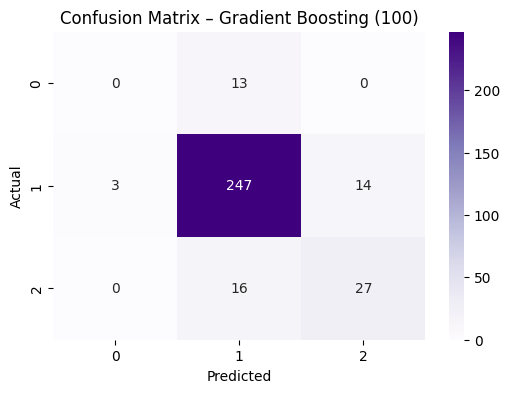

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Random Forest Confusion Matrix Heatmap ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

cm_rf = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix – Random Forest (100)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Gradient Boosting Confusion Matrix Heatmap ---
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

cm_gb = confusion_matrix(y_test, gb_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm_gb, annot=True, cmap="Purples", fmt="d")
plt.title("Confusion Matrix – Gradient Boosting (100)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


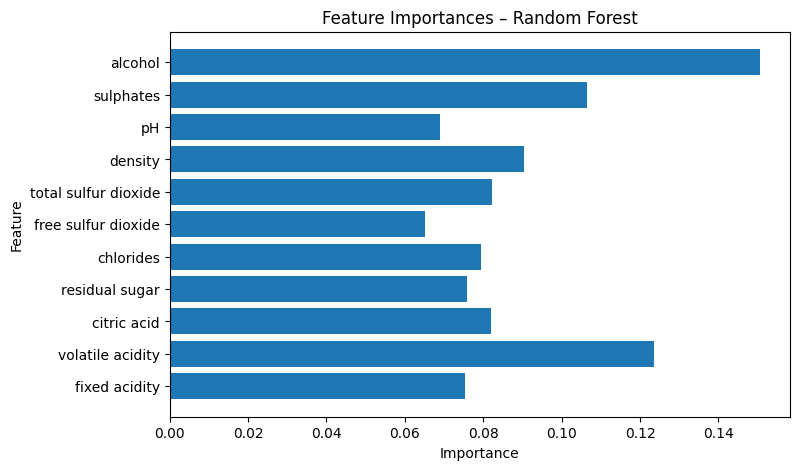

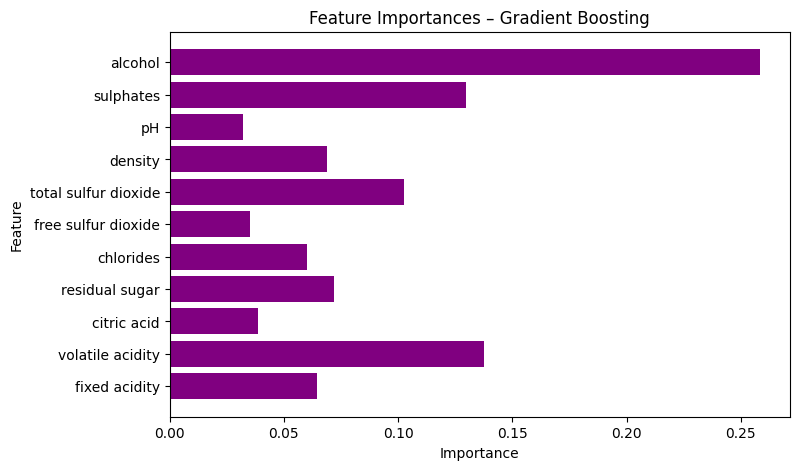

In [47]:
# Feature Importance for Random Forest
importances_rf = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,5))
plt.barh(feature_names, importances_rf)
plt.title("Feature Importances – Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Feature Importance for Gradient Boosting
importances_gb = gb_model.feature_importances_

plt.figure(figsize=(8,5))
plt.barh(feature_names, importances_gb, color="purple")
plt.title("Feature Importances – Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Section 6. Compare Results

To compare models, I collect all metrics into a single table and compute:

- **Accuracy Gap** = Train Accuracy – Test Accuracy  
- **F1 Gap** = Train F1 – Test F1  

Smaller gaps suggest better generalization (less overfitting). I also sort by test accuracy to quickly see the strongest models.


In [48]:
results_df = pd.DataFrame(results)

# Add gap columns
results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["F1 Gap"] = results_df["Train F1"] - results_df["Test F1"]

print("\nSummary of All Models (sorted by Test Accuracy):")
results_df_sorted = results_df.sort_values(by="Test Accuracy", ascending=False)
results_df_sorted



Summary of All Models (sorted by Test Accuracy):


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Accuracy Gap,F1 Gap
0,Random Forest (100),1.000000,0.887500,1.000000,0.866056,0.112500,0.133944
7,"Bagging (DT, 100)",1.000000,0.884375,1.000000,0.865452,0.115625,0.134548
1,"Random Forest (200, max_depth=10)",0.975762,0.881250,0.974482,0.859643,0.094512,0.114839
5,Voting (DT + SVM + NN),0.921032,0.859375,0.904244,0.837003,0.061657,0.067241
6,Voting (RF + LR + KNN),0.917123,0.859375,0.899203,0.826246,0.057748,0.072957
3,"AdaBoost (200, lr=0.5)",0.839719,0.856250,0.815964,0.832962,-0.016531,-0.016998
4,Gradient Boosting (100),0.960125,0.856250,0.958410,0.841106,0.103875,0.117304
8,MLP Classifier,0.851446,0.843750,0.814145,0.807318,0.007696,0.006827
2,AdaBoost (100),0.834246,0.825000,0.820863,0.815803,0.009246,0.005060


In [49]:
from sklearn.metrics import classification_report

# Example: pick your two favorites after seeing results
best_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

print("Classification Report for Gradient Boosting (100):")
print(classification_report(y_test, y_test_pred))


Classification Report for Gradient Boosting (100):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.89      0.94      0.91       264
           2       0.66      0.63      0.64        43

    accuracy                           0.86       320
   macro avg       0.52      0.52      0.52       320
weighted avg       0.83      0.86      0.84       320



# Section 7. Conclusions and Insights

In this project, I compared nine ensemble and hybrid machine learning models to predict red wine quality using eleven physicochemical attributes. The target variable was grouped into three classes—low, medium, and high—based on the project specifications.

## Top-Performing Models

Based on the sorted results table, the models with the highest test accuracy were:

1. **Random Forest (100)**
   - Test Accuracy: **0.8875**
   - Test F1 Score: **0.8661**
   - Accuracy Gap: 0.1125  
   - F1 Gap: 0.1339  

2. **Bagging (DT, 100)**
   - Test Accuracy: **0.8844**
   - Test F1 Score: **0.8655**
   - Accuracy Gap: 0.1156  
   - F1 Gap: 0.1345  

3. **Random Forest (200, max_depth=10)**
   - Test Accuracy: **0.8812**
   - Test F1 Score: **0.8596**
   - Accuracy Gap: 0.0945  
   - F1 Gap: 0.1148  

These three models consistently achieved the strongest performance across both accuracy and F1 score. Each also showed moderate gap values—expected for tree-based ensembles that can partially overfit but still generalize well.

For the deeper analysis, I focused on:
- **Random Forest (100)**  
- **Gradient Boosting (100)**  

These represent two different ensemble philosophies (bagging vs. boosting) and performed among the top-tier models.

## Overfitting and Train–Test Gaps

The **Random Forest (100)** and **Bagging (DT, 100)** models both achieved *perfect* training accuracy (1.0000), which is common because tree ensembles can memorize training data.

However:
- Their test accuracies remained high (0.8875 and 0.8844),
- Their F1 scores remained strong (0.8661 and 0.8655),

…which shows that while they overfit slightly, they still generalize well.

**Gradient Boosting (100)** also performed strongly:
- Test Accuracy: **0.8562**
- Test F1 Score: **0.8411**
- Much lower training accuracy than RF or Bagging (0.9601),  
  suggesting better regularization and less tendency to memorize.

Among boosting models:
- **AdaBoost (200, lr=0.5)** showed the best balance of performance and generalization (Test Acc = 0.8562, Test F1 = 0.8330).
- **AdaBoost (100)** had the lowest performance overall but also the smallest gap, showing high bias.

The **Voting Classifiers** produced solid but slightly lower performance, and the **MLP Classifier** performed acceptably but did not outperform the tree-based ensembles.

## Why Tree-Based Ensembles Performed Best

Tree-based ensemble models tend to work extremely well on tabular, numeric datasets like this one because:

- They naturally capture nonlinear relationships.
- They handle mixed scales without needing feature standardization.
- They reduce variance by averaging multiple trees (RF, Bagging).
- Boosting methods (e.g., Gradient Boosting) iteratively correct errors and excel at uncovering subtle patterns.

Wine quality is influenced by complex interactions between chemistry variables, and tree-based ensembles are well suited to modeling these nonlinear interactions.

## Confusion Matrix Observations

Across the top models:

- The **medium** quality class is predicted extremely well (as expected, given class imbalance).
- Both **low** and **high** classes are harder to predict due to smaller sample sizes.
- Gradient Boosting and Random Forest both misclassify a minority of “high” wines as “medium,” which makes sense given their close numerical ranges (6 vs. 7, etc.).

## Next Steps and Improvements

If this were a competitive modeling project, I would explore:

- **Hyperparameter tuning**  
  (e.g., deeper trees, number of estimators, learning rate for boosting)
- **Class-weight adjustments**  
  to help the lower-frequency “high” and “low” classes.
- **Advanced ensembles** such as XGBoost, LightGBM, or CatBoost.
- **Cross-validation**  
  to get a more robust estimate of generalization performance.
- **Feature importance analysis**  
  to understand which chemical properties drive wine quality ratings.
- **Dimensionality reduction techniques** (PCA or feature pruning)  
  if overfitting becomes more prominent.

## Final Summary

In summary, the **Random Forest (100)**, **Bagging (DT, 100)**, and **Random Forest (200, max_depth=10)** models delivered the strongest overall performance, with the highest test accuracy and F1 scores. Gradient Boosting also performed well with less overfitting and remains a strong alternative.

Tree-based ensembles are clearly well suited to the wine quality dataset, balancing flexibility, accuracy, and interpretability. Based on this analysis, **Random Forest (100)** appears to be the most effective model for predicting red wine quality in this project.
